In [1]:
pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

In [3]:
root_directory = '/content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset'
patch_size = 256

In [4]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 

In [5]:

for path, subdirs, files in sorted(os.walk(root_directory)):
    print(files) 

['classes.json']
[]
['image_part_008.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_001.jpg', 'image_part_004.jpg', 'image_part_003.jpg', 'image_part_005.jpg', 'image_part_009.jpg', 'image_part_002.jpg']
['image_part_008.png', 'image_part_009.png', 'image_part_004.png', 'image_part_007.png', 'image_part_002.png', 'image_part_006.png', 'image_part_001.png', 'image_part_005.png', 'image_part_003.png']
[]
['image_part_004.jpg', 'image_part_009.jpg', 'image_part_001.jpg', 'image_part_002.jpg', 'image_part_008.jpg', 'image_part_007.jpg', 'image_part_006.jpg', 'image_part_003.jpg', 'image_part_005.jpg']
['image_part_005.png', 'image_part_004.png', 'image_part_007.png', 'image_part_003.png', 'image_part_006.png', 'image_part_001.png', 'image_part_009.png', 'image_part_002.png', 'image_part_008.png']
[]
['image_part_009.jpg', 'image_part_006.jpg', 'image_part_008.jpg', 'image_part_005.jpg', 'image_part_007.jpg', 'image_part_001.jpg', 'image_part_003.jpg', 'image_part_004.jpg', '

In [6]:
image_dataset = []  
for path, subdirs, files in sorted(os.walk(root_directory)):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, image_name in sorted(enumerate(images)):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_007.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/T

In [7]:
mask_dataset = []  
for path, subdirs, files in sorted(os.walk(root_directory)):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 

Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_001.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_002.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_003.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_004.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_005.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_006.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_007.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/ima

In [8]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

mask_dataset.shape

(820, 256, 256, 3)

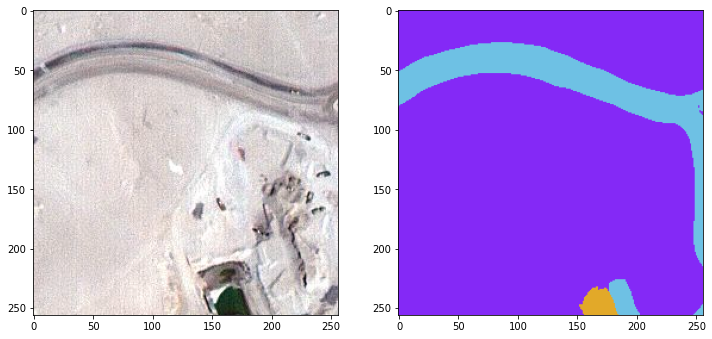

In [9]:
## THIS IS THE MOST IMPORTANT STEP THAT SHOULD BE DONE
#IF THE MASK AND IMAGE ARE NOT IN SAME ORDER THEN OUR MODEL GETS WRONGLY TRAINED
#HENCE BEFORE FITTING INTO MODEL WE SHOULD CHECK WHETHER THEY ARE IN SAME ORDER OR NOT

#Sanity check, view few mages


import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [10]:
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F
Example: RGB --> R=201, G=, B=
R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)
Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152

"""

'\nRGB to HEX: (Hexadecimel --> base 16)\nThis number divided by sixteen (integer division; ignoring any remainder) gives \nthe first hexadecimal digit (between 0 and F, where the letters A to F represent \nthe numbers 10 to 15). The remainder gives the second hexadecimal digit. \n0-9 --> 0-9\n10-15 --> A-F\nExample: RGB --> R=201, G=, B=\nR = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)\nCalculating RGB from HEX: #3C1098\n3C = 3*16 + 12 = 60\n10 = 1*16 + 0 = 16\n98 = 9*16 + 8 = 152\n\n'

In [11]:
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)

60


In [12]:
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

In [13]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer

def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg


In [14]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


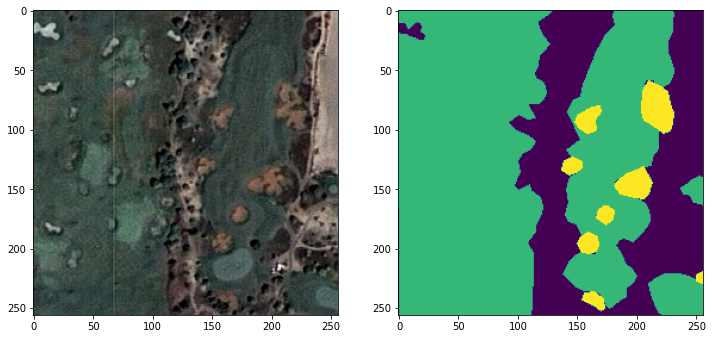

In [15]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


In [16]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [19]:
##  UNET MODEL

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [21]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

X_train.shape[0]
#this reprent sthe no of images in trianing data

656

In [22]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [23]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [24]:

metrics=['accuracy']

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [25]:
history1 = model.fit(X_train,  y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test,  y_test), 
                    shuffle=False)

Epoch 1/50
41/41 [==============================] - 24s 212ms/step - loss: 1.4341 - accuracy: 0.3786 - val_loss: 1.2150 - val_accuracy: 0.4897
Epoch 2/50
41/41 [==============================] - 7s 176ms/step - loss: 1.1589 - accuracy: 0.5016 - val_loss: 1.0435 - val_accuracy: 0.5666
Epoch 3/50
41/41 [==============================] - 7s 178ms/step - loss: 0.9956 - accuracy: 0.6037 - val_loss: 0.9178 - val_accuracy: 0.6742
Epoch 4/50
41/41 [==============================] - 7s 180ms/step - loss: 0.8957 - accuracy: 0.6784 - val_loss: 0.8298 - val_accuracy: 0.7156
Epoch 5/50
41/41 [==============================] - 7s 180ms/step - loss: 0.8329 - accuracy: 0.7084 - val_loss: 0.7826 - val_accuracy: 0.7340
Epoch 6/50
41/41 [==============================] - 7s 181ms/step - loss: 0.7786 - accuracy: 0.7325 - val_loss: 0.7620 - val_accuracy: 0.7409
Epoch 7/50
41/41 [==============================] - 7s 182ms/step - loss: 0.7321 - accuracy: 0.7486 - val_loss: 0.7915 - val_accuracy: 0.7158
Epoch

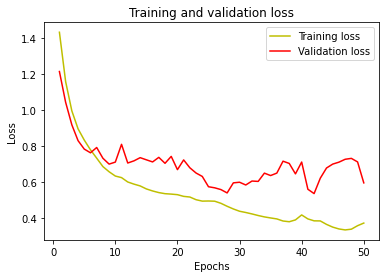

In [26]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

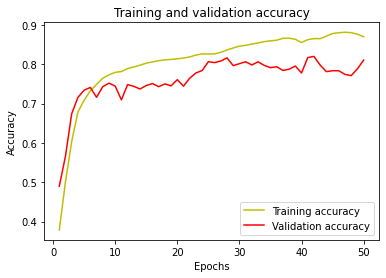

In [27]:
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [33]:
#FUCNTION FOR DISPLAYING IMAGE,MASK,PREDICTED MASK 

def display(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [37]:
#FUNCTION FOR PRINTING PREDICTIONS

def show_predictions(dataset, num):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
model.save('UNET_AERIAL_IMAGERY1.h5')

In [38]:
len(X_test)

164

In [39]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

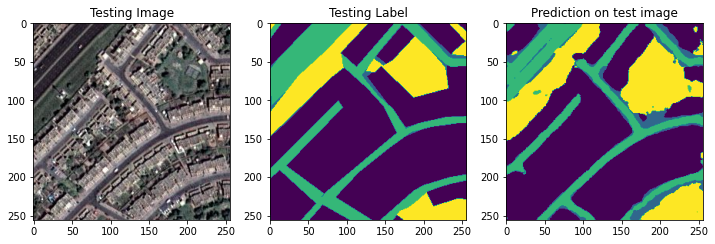

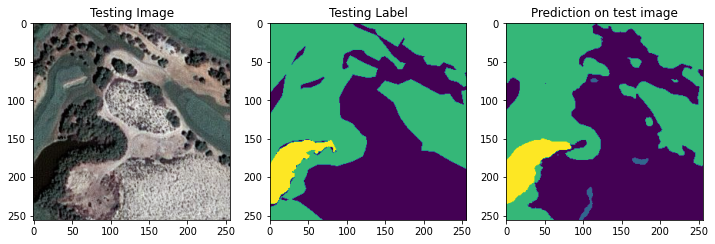

In [90]:
import random
 
res = random.sample(range(1, 164), 2)

for i in res:
  test_img_number = i
  test_img = X_test[test_img_number]
  ground_truth=y_test_argmax[test_img_number]

  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]

  plt.figure(figsize=(12, 8))
  plt.subplot(2,3,1)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(2,3,2)
  plt.title('Testing Label')
  plt.imshow(ground_truth)
  plt.subplot(2,3,3)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img)
  plt.show()


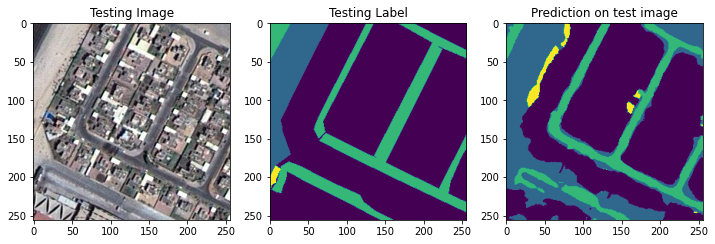

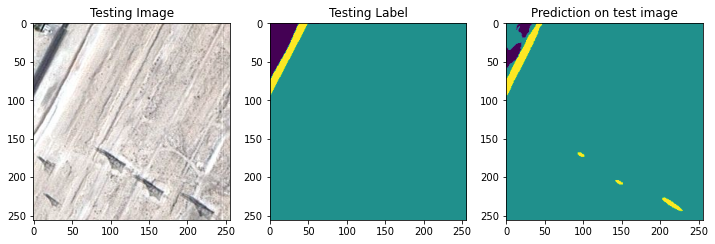

In [91]:
#PREDICTIONS